In [ ]:
import os
import tarfile
from tqdm import tqdm
import requests

# Constants
DATASET_PATH = "gtzan_dataset/genres"
TAR_GZ_URL = "https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz"
TAR_GZ_PATH = os.path.join("gtzan_dataset", "genres.tar.gz")

In [ ]:

# Function to download and extract the dataset if not already present
def download_and_extract_dataset():
    if not os.path.exists(DATASET_PATH) or len(os.listdir(DATASET_PATH)) == 0:
        os.makedirs("gtzan_dataset", exist_ok=True)

        print(f"Dataset not found at {DATASET_PATH}. Downloading...")

        # Descargar con requests para mostrar progreso en Colab
        response = requests.get(TAR_GZ_URL, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(TAR_GZ_PATH, "wb") as file, tqdm(
            desc="Downloading genres.tar.gz",
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
                    progress_bar.update(len(chunk))

        print("Extracting the dataset...")
        with tarfile.open(TAR_GZ_PATH, "r:gz") as tar:
            tar.extractall(path="gtzan_dataset")

        os.remove(TAR_GZ_PATH)
        print(f"✅ Dataset downloaded and extracted in {DATASET_PATH}")
    else:
        print("✅ Dataset already exists.")

In [ ]:
# Run it
download_and_extract_dataset()

Dataset not found at gtzan_dataset/genres. Downloading...


/tmp/ipython-input-2190400590.py:26: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="gtzan_dataset")


Extracting the dataset...
✅ Dataset downloaded and extracted in gtzan_dataset/genres


# Una ejemplo de un track de música clásica vs. blues

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os

# Directorios
dir_classical = '/content/gtzan_dataset/genres/classical'
dir_pop = '/content/gtzan_dataset/genres/pop'

# Buscar archivos válidos
audio_classical = [f for f in os.listdir(dir_classical) if f.endswith('.wav') and not f.startswith('._')]
audio_pop = [f for f in os.listdir(dir_pop) if f.endswith('.wav') and not f.startswith('._')]

if audio_classical and audio_pop:
    file_classical = os.path.join(dir_classical, audio_classical[0])
    file_pop = os.path.join(dir_pop, audio_pop[0])

    y_classical, sr_classical = librosa.load(file_classical)
    y_pop, sr_pop = librosa.load(file_pop)

    # 🎧 Reproducir ambos
    print("🎶 Classical")
    display(Audio(filename=file_classical))
    print("🎶 Pop")
    display(Audio(filename=file_pop))
else:
    print("No se encontraron archivos válidos en ambos géneros.")


🎶 Classical


🎶 Pop


# Onda cruda (waveform)

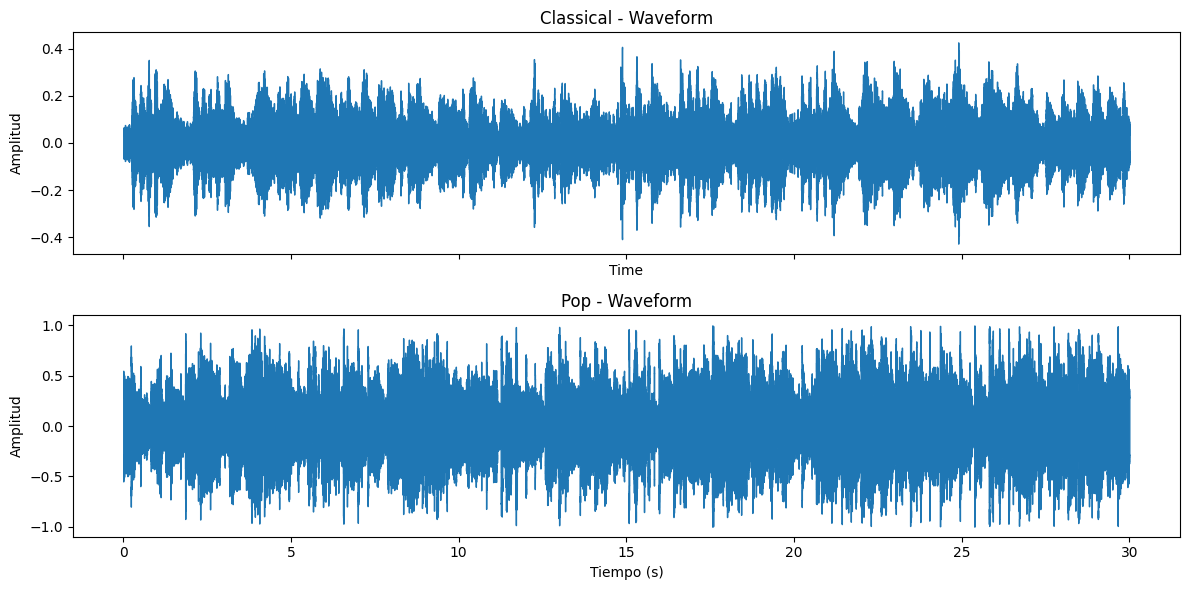

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

librosa.display.waveshow(y_classical, sr=sr_classical, ax=ax[0])
ax[0].set(title='Classical - Waveform', ylabel='Amplitud')

librosa.display.waveshow(y_pop, sr=sr_pop, ax=ax[1])
ax[1].set(title='Pop - Waveform', xlabel='Tiempo (s)', ylabel='Amplitud')

plt.tight_layout()
plt.show()



# Espectrograma de Mel

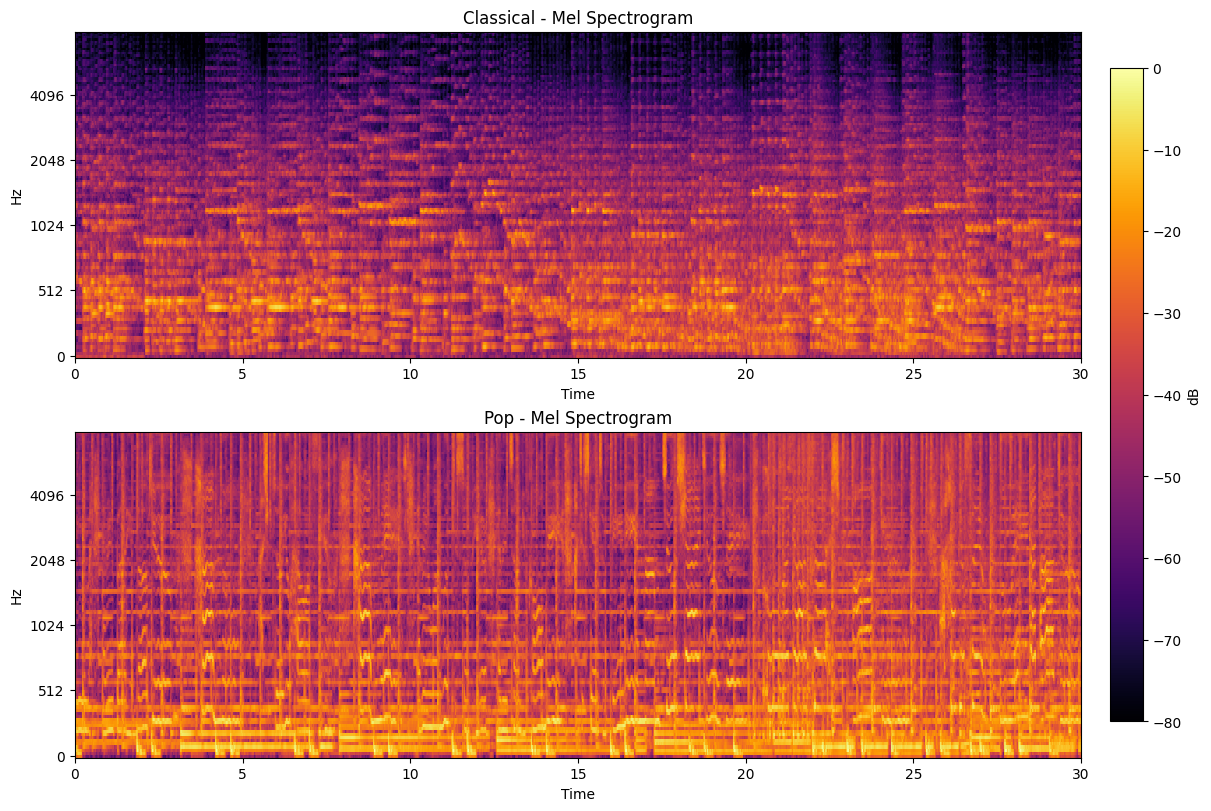

In [ ]:
# --- Parámetros comunes ---
target_sr = 22050
n_fft = 2048
hop_length = 512
n_mels = 128
fmax = 8000

# (Re)cargar ambos a la MISMA tasa para comparar
y_classical, _ = librosa.load(file_classical, sr=target_sr)
y_pop, _       = librosa.load(file_pop,       sr=target_sr)

# Mel power spectrograms (misma config)
S_c = librosa.feature.melspectrogram(y=y_classical, sr=target_sr,
                                     n_fft=n_fft, hop_length=hop_length,
                                     n_mels=n_mels, fmax=fmax)
S_p = librosa.feature.melspectrogram(y=y_pop, sr=target_sr,
                                     n_fft=n_fft, hop_length=hop_length,
                                     n_mels=n_mels, fmax=fmax)
# ---- ESCALA COMÚN EN dB ----
# Usamos el mayor valor de potencia global como referencia,
# y además forzamos el rango [-80, 0] dB para comparabilidad visual.
ref_power = max(S_c.max(), S_p.max())
S_c_db = librosa.power_to_db(S_c, ref=ref_power)
S_p_db = librosa.power_to_db(S_p, ref=ref_power)
vmin, vmax = -80, 0


fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = fig.add_gridspec(2, 1)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

im1 = librosa.display.specshow(S_c_db, sr=target_sr, x_axis='time', y_axis='mel',
                               fmax=fmax, vmin=vmin, vmax=vmax,cmap="inferno", ax=ax1)
ax1.set_title('Classical - Mel Spectrogram')
ax1.set_ylabel('Hz')

im2 = librosa.display.specshow(S_p_db, sr=target_sr, x_axis='time', y_axis='mel',
                               fmax=fmax, vmin=vmin, vmax=vmax,cmap="inferno", ax=ax2)
ax2.set_title('Pop - Mel Spectrogram')
ax2.set_xlabel('Time')
ax2.set_ylabel('Hz')

# Barra de color compartida (¡no uses tight_layout aquí!)
cbar = fig.colorbar(im2, ax=[ax1, ax2], location='right', pad=0.02, shrink=0.9)
cbar.set_label('dB')

plt.show()



# Onsets y beats

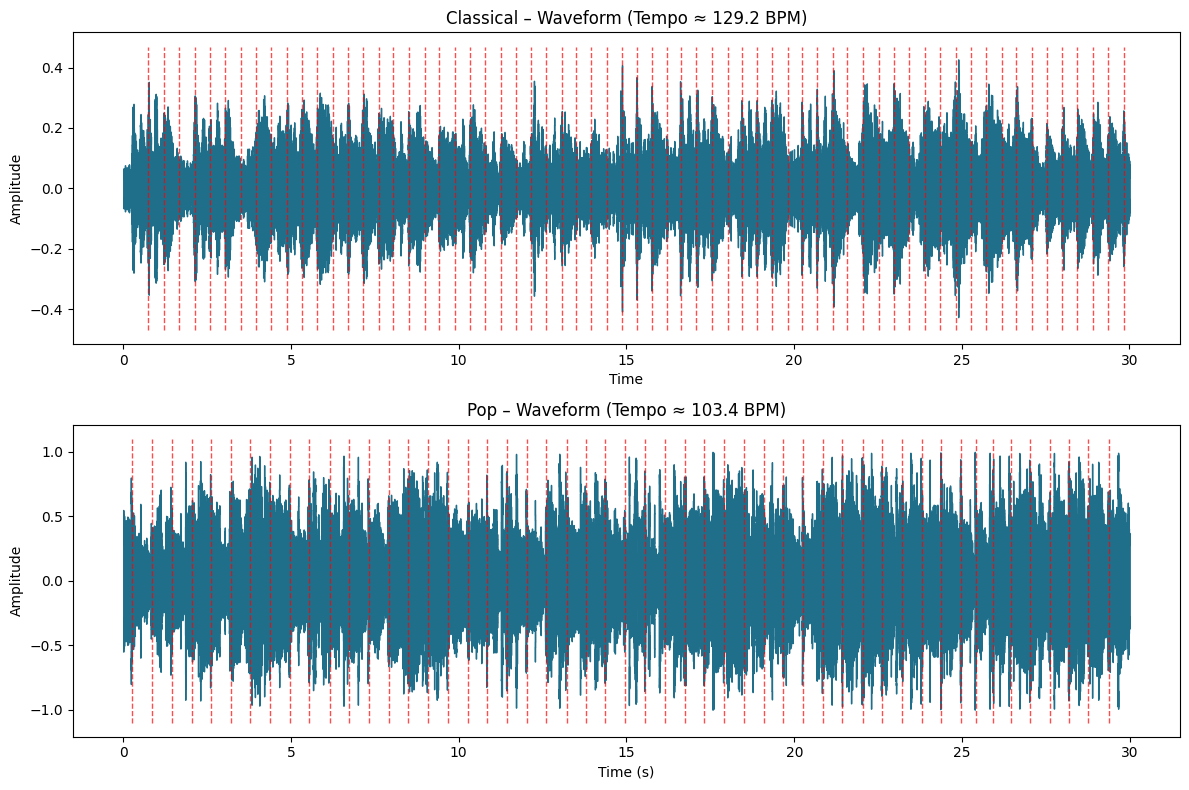

In [ ]:
# === WAVEFORM + BEATS (Classical vs Pop) ===
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display

def rhythm_features(y, sr, hop_length=512):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempo_bt, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    tempo_bt = float(np.array(tempo_bt).reshape(-1)[0])  # asegurar escalar
    beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
    return tempo_bt, beat_times

# Calcular beats y tempo
t_c, beat_c_times = rhythm_features(y_classical, sr_classical)
t_p, beat_p_times = rhythm_features(y_pop, sr_pop)

# --- PLOT ---
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Classical
librosa.display.waveshow(y_classical, sr=sr_classical, ax=ax[0], color="#1f6f8b")
if beat_c_times.size > 0:
    ax[0].vlines(beat_c_times, ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1],
                 colors='r', alpha=0.7, linestyles="--", linewidth=1)
ax[0].set_title(f"Classical – Waveform (Tempo ≈ {t_c:.1f} BPM)")
ax[0].set_ylabel("Amplitude")

# Pop
librosa.display.waveshow(y_pop, sr=sr_pop, ax=ax[1], color="#1f6f8b")
if beat_p_times.size > 0:
    ax[1].vlines(beat_p_times, ymin=ax[1].get_ylim()[0], ymax=ax[1].get_ylim()[1],
                 colors='r', alpha=0.7, linestyles="--", linewidth=1)
ax[1].set_title(f"Pop – Waveform (Tempo ≈ {t_p:.1f} BPM)")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()



# Tonnetz y Chroma

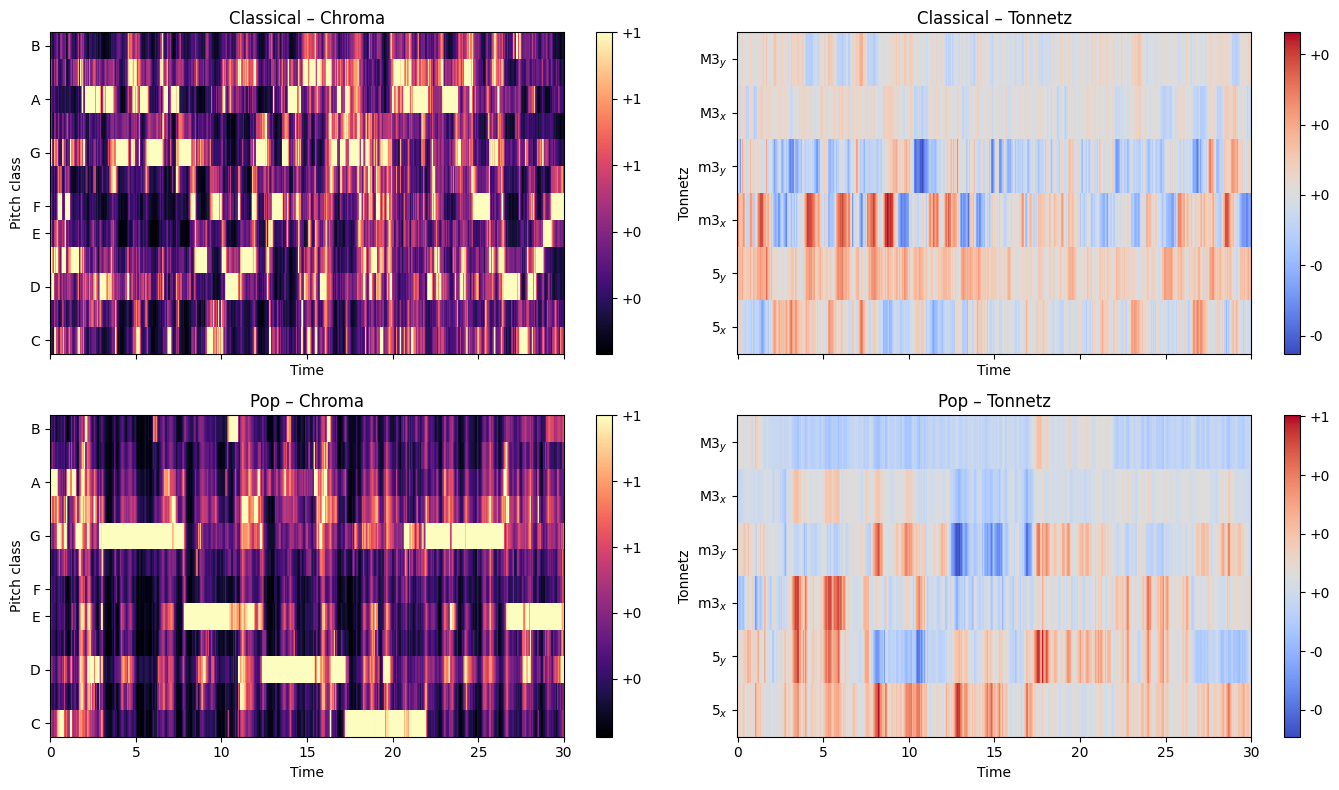

In [ ]:
# === CHROMA & TONNETZ (Classical vs Pop) ===
import librosa
import librosa.display

# --- Extraer chroma y tonnetz para ambos ---
chroma_classical = librosa.feature.chroma_cqt(y=y_classical, sr=sr_classical)
tonnetz_classical = librosa.feature.tonnetz(y=y_classical, sr=sr_classical)

chroma_pop = librosa.feature.chroma_cqt(y=y_pop, sr=sr_pop)
tonnetz_pop = librosa.feature.tonnetz(y=y_pop, sr=sr_pop)

# --- Plot ---
fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Classical – Chroma
img1 = librosa.display.specshow(chroma_classical, y_axis='chroma', x_axis='time',
                                ax=ax[0, 0])
ax[0, 0].set_title("Classical – Chroma")
fig.colorbar(img1, ax=ax[0, 0], format='%+2.0f')

# Classical – Tonnetz
img2 = librosa.display.specshow(tonnetz_classical, y_axis='tonnetz', x_axis='time',
                                ax=ax[0, 1])
ax[0, 1].set_title("Classical – Tonnetz")
fig.colorbar(img2, ax=ax[0, 1], format='%+2.0f')

# Pop – Chroma
img3 = librosa.display.specshow(chroma_pop, y_axis='chroma', x_axis='time',
                               ax=ax[1, 0])
ax[1, 0].set_title("Pop – Chroma")
fig.colorbar(img3, ax=ax[1, 0], format='%+2.0f')

# Pop – Tonnetz
img4 = librosa.display.specshow(tonnetz_pop, y_axis='tonnetz', x_axis='time',
                                ax=ax[1, 1])
ax[1, 1].set_title("Pop – Tonnetz")
fig.colorbar(img4, ax=ax[1, 1], format='%+2.0f')

plt.tight_layout()
plt.show()


# Análisis SHAP

In [1]:
!pip install shap

# Características manuales

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Cargar datos
df = pd.read_csv("/content/gtzan_supervector_cmmcc_33coef.csv")

# X / y (quita 'filename' si está)
X = df.drop(columns=[c for c in ["filename", "label"] if c in df.columns])
y = df["label"]

# Escalado (opcional para LGBM, pero lo dejas como en tu patrón)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.3, random_state=42
)

# Entrenar modelo
model = LGBMClassifier(verbosity=-1, random_state=42)
model.fit(X_train, y_train)

# Métrica rápida
y_pred = model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))


Accuracy: 0.72


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [5]:
print(X.shape)
print(model)

(999, 156)
LGBMClassifier(random_state=42, verbosity=-1)


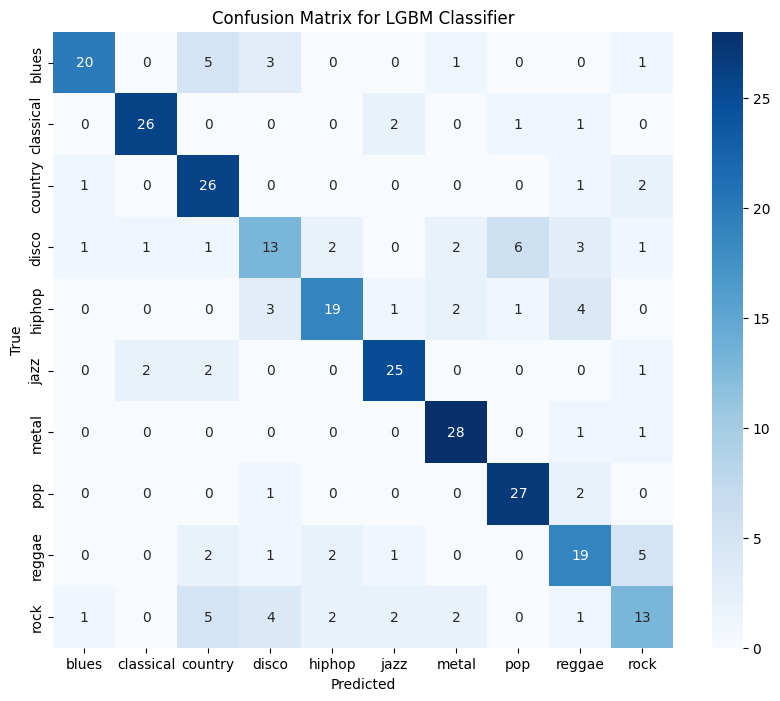

In [6]:
# prompt: haz una matriz de confusión con seaborn de model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ... (your existing code) ...

# Assuming 'y_test' and 'y_pred' are defined from your LGBM model
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for LGBM Classifier")
plt.show()


#Aplicar SHAP con TreeExplainer para todo el conjunto de datos X

In [7]:
import shap
# Usar TreeExplainer (más rápido y nativo para LGBM)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

In [8]:
print("Tipo de shap_values:", type(shap_values))
print("dimensiones de shap_values:", shap_values.shape)

Tipo de shap_values: <class 'shap._explanation.Explanation'>
dimensiones de shap_values: (999, 156, 10)


(999, 156)


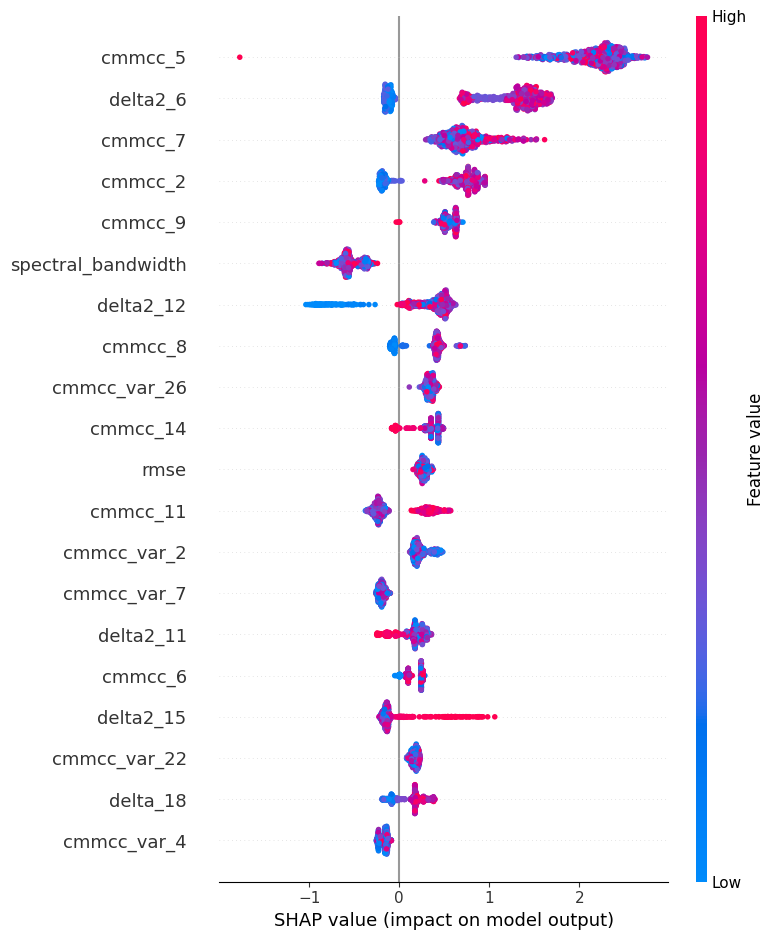

In [9]:
# Crear nombres de columnas
feature_names = (
    [f"cmmcc_{i}" for i in range(33)] +
    [f"cmmcc_var_{i}" for i in range(33)] +
    [f"delta_{i}" for i in range(33)] +
    [f"delta2_{i}" for i in range(33)] +
    [f"chroma_{i}" for i in range(12)] +
    [f"tonnetz_{i}" for i in range(6)] +
    ["spectral_centroid", "spectral_bandwidth", "spectral_rolloff", "zero_crossing_rate", "rmse"] +
    ["tempo"]
)


X_df = pd.DataFrame(X, columns=feature_names)
print(X_df.shape)
# Usar directamente shap_values[1] sin transponer
shap.summary_plot(shap_values[:, :, 0], X_df, plot_type="dot")  # Clase 0

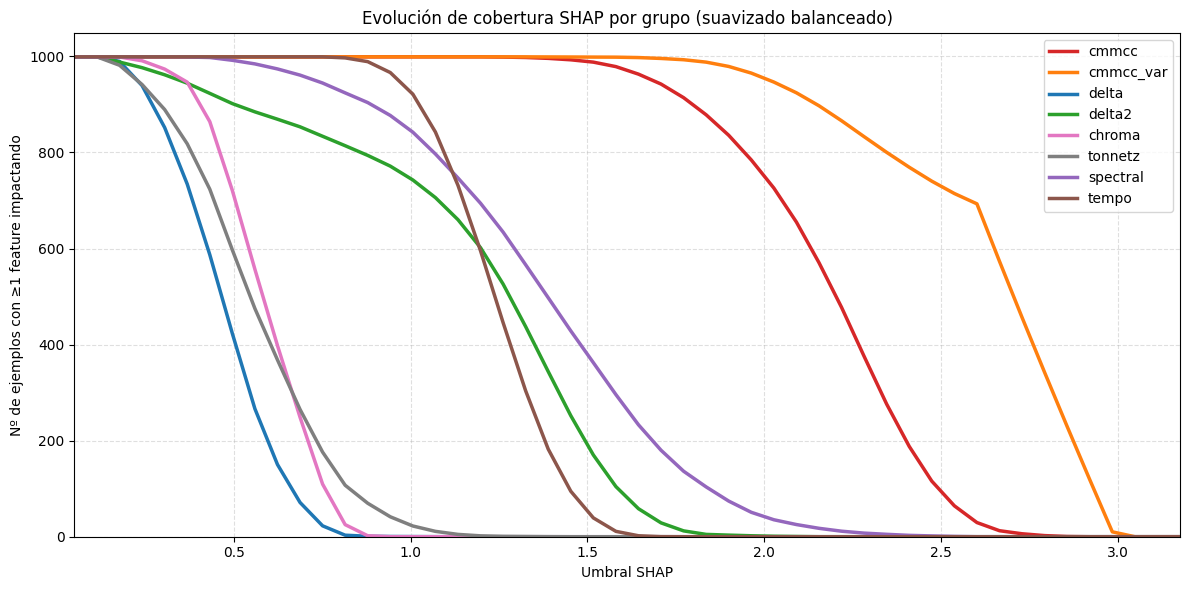

In [12]:
grupos = {
    "cmmcc":     feature_names[0:33],     # 33
    "cmmcc_var": feature_names[33:66],    # 33
    "delta":     feature_names[66:99],    # 33
    "delta2":    feature_names[99:132],   # 33
    "chroma":    feature_names[132:144],  # 12
    "tonnetz":   feature_names[144:150],  # 6
    "spectral":  feature_names[150:155],  # 5
    "tempo":     feature_names[155:156],  # 1
}

import numpy as np
import matplotlib.pyplot as plt

# Calcular valores extremos
shap_abs = np.abs(shap_values.values)  # (999, 156, 10)
shap_max = shap_abs.max()
shap_min = shap_abs.min()

# Rango de umbrales

thresholds = np.linspace(0.05, shap_max, 50)

# Contenedor de resultados
evolucion_grupos = {grupo: [] for grupo in grupos}

# Procesar cada grupo
for grupo, columnas in grupos.items():
    idx = [feature_names.index(col) for col in columnas]
    shap_group = shap_abs[:, idx, :].max(axis=2)  # (999, n_features_del_grupo)

    for t in thresholds:
        # Contar ejemplos donde al menos 2 features del grupo superan el umbral t
        impacto = (shap_group > t).sum(axis=1)
        n_ejemplos = np.sum(impacto >= 1)
        evolucion_grupos[grupo].append(n_ejemplos)

colores_grupo = {
    'cmmcc_var': '#FF7F0E',  # naranja
    'cmmcc': '#D62728',      # rojo
    'spectral': '#9467BD',  # morado
    'tempo': '#8C564B',     # marrón
    'delta2': '#2CA02C',    # verde
    'delta': '#1F77B4',     # azul
    'chroma': '#E377C2',    # rosa
    'tonnetz': '#7F7F7F'    # gris
}

def suavizar_central(y, w=4):
    y_conv = np.convolve(y, np.ones(w)/w, mode='valid')
    pad_left = [y[0]] * ((w - 1) // 2)
    pad_right = [y[-1]] * ((w - 1) - (w - 1) // 2)
    return np.array(pad_left + list(y_conv) + pad_right)

plt.figure(figsize=(12, 6))
for grupo, valores in evolucion_grupos.items():
    curva = suavizar_central(valores, w=6)
    plt.plot(thresholds, curva, label=grupo, linewidth=2.5, color=colores_grupo[grupo])

plt.title("Evolución de cobertura SHAP por grupo (suavizado balanceado)")
plt.xlabel("Umbral SHAP")
plt.ylabel("Nº de ejemplos con ≥1 feature impactando")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlim(thresholds.min(), thresholds.max())
plt.ylim(0, max(max(v) for v in evolucion_grupos.values())+50)
plt.tight_layout()
plt.show()


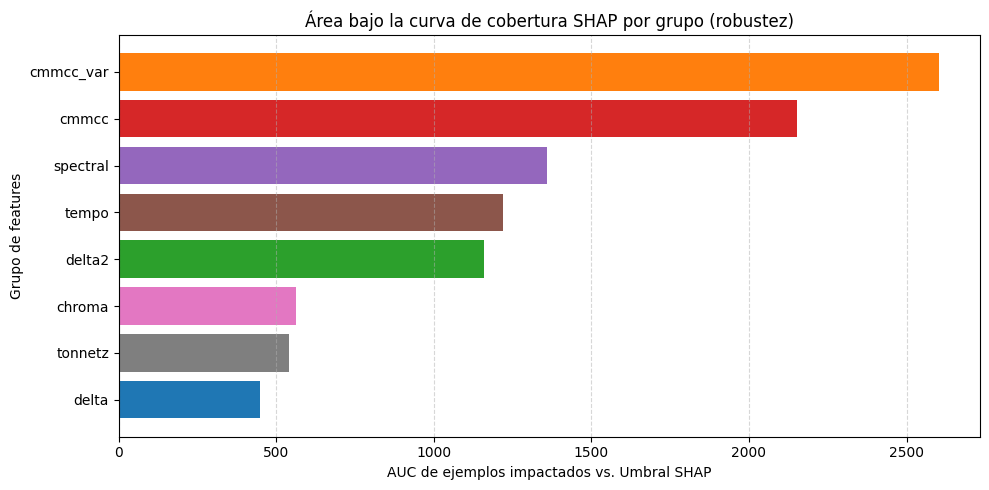

In [14]:
from sklearn.metrics import auc


# Calcular área bajo la curva para cada grupo
auc_por_grupo = {
    grupo: auc(thresholds, valores)
    for grupo, valores in evolucion_grupos.items()
}

df_auc = pd.DataFrame.from_dict(auc_por_grupo, orient='index', columns=['AUC_SHAP_Cobertura'])
df_auc = df_auc.sort_values('AUC_SHAP_Cobertura', ascending=False)

# 📊 Gráfico en horizontal
plt.figure(figsize=(10, 5))
plt.barh(df_auc.index, df_auc['AUC_SHAP_Cobertura'],
         color=[colores_grupo[g] for g in df_auc.index])
plt.title("Área bajo la curva de cobertura SHAP por grupo (robustez)")
plt.xlabel("AUC de ejemplos impactados vs. Umbral SHAP")
plt.ylabel("Grupo de features")
plt.gca().invert_yaxis()  # mayor valor arriba
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Embeddings de CLAP

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Cargar embeddings de CLAP
df_clap = pd.read_csv("/content/gtzan_clap_embeddings_8925.csv")

#
X_clap = df_clap.drop(columns=[c for c in ["filename", "label"] if c in df_clap.columns])
y_clap = df_clap["label"]

# Escalado (opcional para LGBM, pero lo dejamos como en tu patrón)
scaler_clap = StandardScaler()
X_clap_scaled = scaler_clap.fit_transform(X_clap)

# Split estratificado
X_clap_train, X_clap_test, y_clap_train, y_clap_test = train_test_split(
    X_clap_scaled, y_clap, stratify=y_clap, test_size=0.3, random_state=42
)

# Entrenar modelo
model_clap = LGBMClassifier(verbosity=-1, random_state=42)
model_clap.fit(X_clap_train, y_clap_train)

# Métrica rápida
y_clap_pred = model_clap.predict(X_clap_test)
print("Accuracy CLAP:", round(accuracy_score(y_clap_test, y_clap_pred), 4))



Accuracy CLAP: 0.84


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [18]:
print(X_clap.shape)
print(model_clap)

(999, 512)
LGBMClassifier(random_state=42, verbosity=-1)


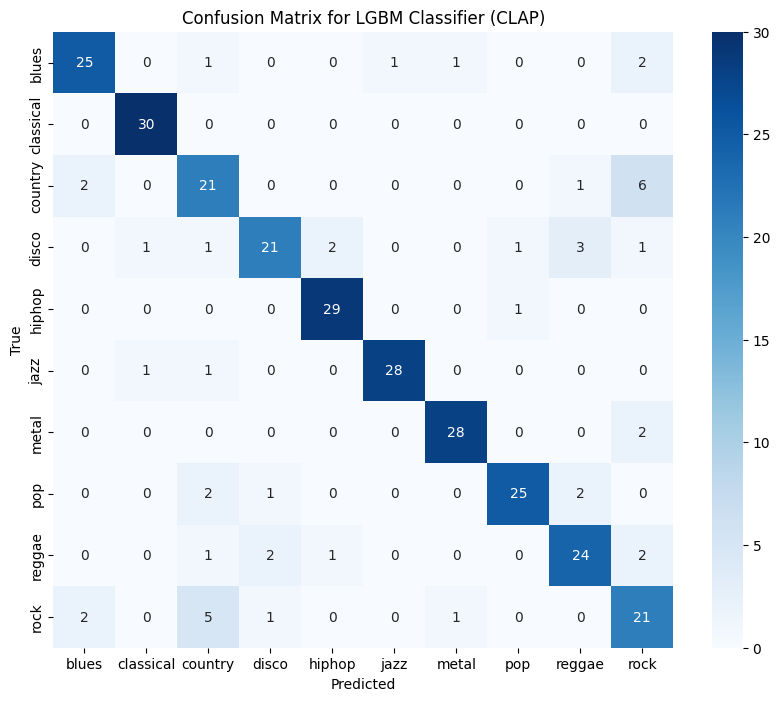

In [17]:
# 📊 Matriz de confusión con seaborn para CLAP
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm_clap = confusion_matrix(y_clap_test, y_clap_pred)

# Dibujar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_clap, annot=True, fmt="d", cmap="Blues",
    xticklabels=np.unique(y_clap), yticklabels=np.unique(y_clap)
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for LGBM Classifier (CLAP)")
plt.show()


#Aplicar SHAP con TreeExplainer para todo el conjunto de datos X_clap

In [23]:
import shap
# Usar TreeExplainer (más rápido y nativo para LGBM)
explainer = shap.TreeExplainer(model_clap)
shap_values_clap = explainer(X_clap)

In [25]:
print("Tipo de shap_values:", type(shap_values))
print("dimensiones de shap_values:", shap_values_clap.shape)

Tipo de shap_values: <class 'shap._explanation.Explanation'>
dimensiones de shap_values: (999, 512, 10)


X_clap_df shape: (999, 512)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


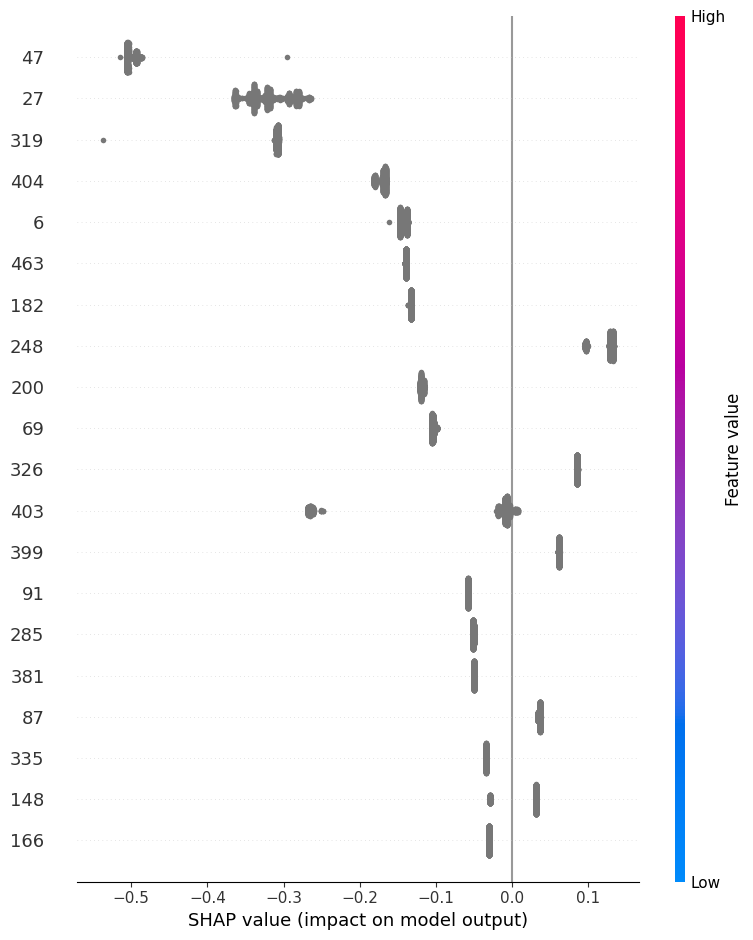

In [26]:
import pandas as pd
import shap

# Número de dimensiones del embedding CLAP
n_features_clap = X_clap.shape[1]

# Crear nombres de columnas: embed_0, embed_1, ...
feature_names_clap = [f"embed_{i}" for i in range(n_features_clap)]

# DataFrame con los embeddings CLAP
X_clap_df = pd.DataFrame(X_clap, columns=feature_names_clap)
print("X_clap_df shape:", X_clap_df.shape)

# Selección de clase (índice 0–9 según LabelEncoder de GTZAN)
class_idx = 0   # ej: 0 = blues, 1 = classical, etc.

# Graficar explicaciones SHAP
shap.summary_plot(shap_values_clap[:, :, class_idx], X_clap_df, plot_type="dot")


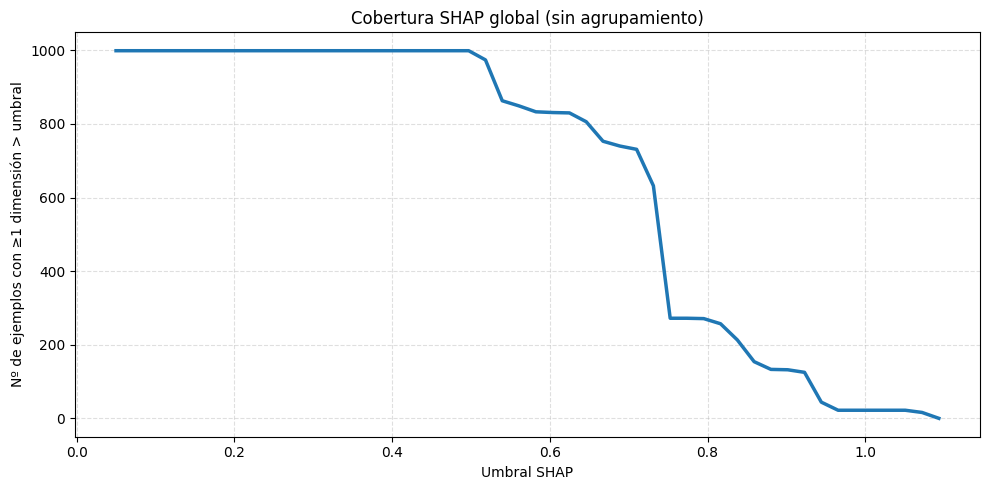

AUC global de cobertura SHAP (sin grupos): 688.186
AUC global normalizado: 0.689


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# === 1) Preparar SHAP absolutos (sin grupos) ===
# Usa 'shap_values_clap' como lo tengas:
# - si es shap.Explanation -> usa .values
# - si es lista por clase -> apílalas
# - si es ndarray 3D -> úsalo directo

def shap_to_array_3d(sv):
    import shap
    if isinstance(sv, list):  # lista por clase, cada item (n, m)
        arrs = [x.values if isinstance(x, shap.Explanation) else np.asarray(x) for x in sv]
        return np.stack(arrs, axis=-1)  # (n, m, C)
    if hasattr(sv, "values"):  # shap.Explanation
        vals = sv.values
        if vals.ndim == 2:     # (n, m) -> agrega eje de clase
            return vals[:, :, None]
        if vals.ndim == 3:     # (n, m, C) o (n, C, m)
            # normaliza a (n, m, C)
            return vals if vals.shape[1] == X_clap.shape[1] else vals.transpose(0, 2, 1)
        raise ValueError(f"Forma no soportada: {vals.shape}")
    # ndarray
    vals = np.asarray(sv)
    if vals.ndim == 2: return vals[:, :, None]
    if vals.ndim == 3: return vals if vals.shape[1] == X_clap.shape[1] else vals.transpose(0, 2, 1)
    raise ValueError(f"Forma no soportada: {vals.shape}")

shap_arr_clap = shap_to_array_3d(shap_values_clap)   # (n_samples, n_features, n_classes)

# Agregación sobre clases (elige UNA):
# a) impacto máximo en cualquier clase (visión global)
shap_abs_clap = np.abs(shap_arr_clap).max(axis=2)     # (n, m)

# # b) o una clase específica:
# class_idx = 0
# shap_abs_clap = np.abs(shap_arr_clap[:, :, class_idx])

# === 2) Barrido de umbrales y cobertura global ===
thr_max = shap_abs_clap.max()
thresholds = np.linspace(0.05, thr_max, 50)

# Para cada umbral, cuenta ejemplos con >=1 dimensión por encima del umbral
coverage = []
for t in thresholds:
    num = np.sum((shap_abs_clap > t).any(axis=1))  # True si al menos una dim supera t
    coverage.append(num)

# === 3) Curva y AUC global ===
plt.figure(figsize=(10, 5))
plt.plot(thresholds, coverage, linewidth=2.5)
plt.title("Cobertura SHAP global (sin agrupamiento)")
plt.xlabel("Umbral SHAP")
plt.ylabel("Nº de ejemplos con ≥1 dimensión > umbral")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

auc_global = auc(thresholds, coverage)
print(f"AUC global de cobertura SHAP (sin grupos): {auc_global:.3f}")

# (Opcional) versión normalizada (0–1) para comparar corridas
n_samples = shap_abs_clap.shape[0]
coverage_norm = np.array(coverage) / n_samples
auc_global_norm = auc(thresholds, coverage_norm)
print(f"AUC global normalizado: {auc_global_norm:.3f}")
